In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import pymc3.math as pmath
from scipy import optimize
%matplotlib inline

In [19]:
# random number generator initialization
np.random.seed(123)

n=100
p=20
# intercept, sd of error distribution
alpha,sigma = 1,0.01

# true value of coefficients - exponentially decaying
beta = np.array([2**(1-s) for s in range(p)])
eps = np.random.randn(n)*sigma
X = np.random.randn(n,p)

# observed data
Y = alpha + np.dot(X,beta) + eps

beta

array([  2.00000000e+00,   1.00000000e+00,   5.00000000e-01,
         2.50000000e-01,   1.25000000e-01,   6.25000000e-02,
         3.12500000e-02,   1.56250000e-02,   7.81250000e-03,
         3.90625000e-03,   1.95312500e-03,   9.76562500e-04,
         4.88281250e-04,   2.44140625e-04,   1.22070312e-04,
         6.10351562e-05,   3.05175781e-05,   1.52587891e-05,
         7.62939453e-06,   3.81469727e-06])

Text(0.5,0,'X2')

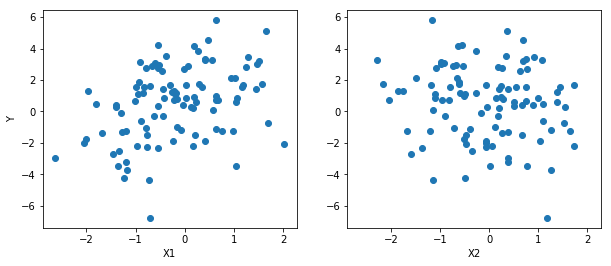

In [20]:
fig, axes = plt.subplots(1,2,sharex=True,figsize=(10,4))
axes[0].scatter(X[:,1],Y)
axes[1].scatter(X[:,7],Y)
axes[0].set_ylabel('Y'); axes[0].set_xlabel('X1'); axes[1].set_xlabel('X2')

Setting up our basic model. Here, we need to create priors for our unknown model parameters and a likelihood (how we expect our data to act, given the model parameters). For a basic regression, this is a Normal distribution (since the errors are assumed to be normally distributed). Additionally, we've added an indicator (Bernoulli variable) that acts like a mask to promote sparsity.

In [21]:
model_one = pm.Model()

with model_one:
    
    # Priors
    ind = pm.Bernoulli('ind',p=0.4,shape=p)
    betaO = pm.Normal('betaO',mu=0,sd=0.001,shape=p)
    betaI = pm.Uniform('betaI',lower=-20,upper=20,shape=p)
    beta = (1-ind)*betaO+ind*betaI
    alpha = pm.Normal('alpha',mu=0,sd=1)
    sigma = pm.HalfNormal('sigma',sd=1)
    # Expected value
    mu = alpha + pmath.dot(X,beta)
    
    # Likelihood
    Y_obs = pm.Normal('Y_obs',mu=mu,sd=sigma,observed=Y)

Let's first do a MAP estimate:

In [7]:
map_estimate = pm.find_MAP(model=model_one)
map_estimate

logp = -191.81, ||grad|| = 43.124: 100%|██████████| 30/30 [00:00<00:00, 3121.54it/s]  


{'alpha': array(0.515741792598083),
 'betaI': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 'betaI_interval__': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 'betaO': array([  3.84855762e-05,   1.48362840e-05,   1.12474424e-05,
          5.19638206e-06,   3.43305467e-06,  -1.60740510e-06,
          1.63977765e-06,  -4.40163943e-06,   6.49872870e-06,
         -3.79819718e-06,   2.10870995e-06,   1.13887769e-06,
          2.10215387e-06,  -1.34474266e-09,  -7.69337440e-06,
         -4.04417351e-06,  -3.65125271e-06,   1.88991088e-06,
         -3.47104056e-06,   2.13787350e-06]),
 'ind': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'sigma': array(2.3129613557932487),
 'sigma_log__': array(0.8385286757138171)}

It looks here like all coefficients have been zeroed out.

Next, let's draw from the posterior:

In [22]:
with model_one:
    trace = pm.sample(5000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [ind]
>NUTS: [sigma_log__, alpha, betaI_interval__, betaO]
 81%|████████▏ | 4473/5500 [00:50<00:11, 89.35it/s]/home/joele119/anaconda2/envs/bayes_env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
100%|█████████▉| 5491/5500 [00:52<00:00, 105.19it/s]/home/joele119/anaconda2/envs/bayes_env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
100%|██████████| 5500/5500 [00:52<00:00, 105.32it/s]
/home/joele119/anaconda2/envs/bayes_env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/joele119/anaconda2/envs/bayes_env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
Tuning was enabled throughout the whole trace.
Tuning was enabled through

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f63cf279320>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f63ced88e10>]], dtype=object)

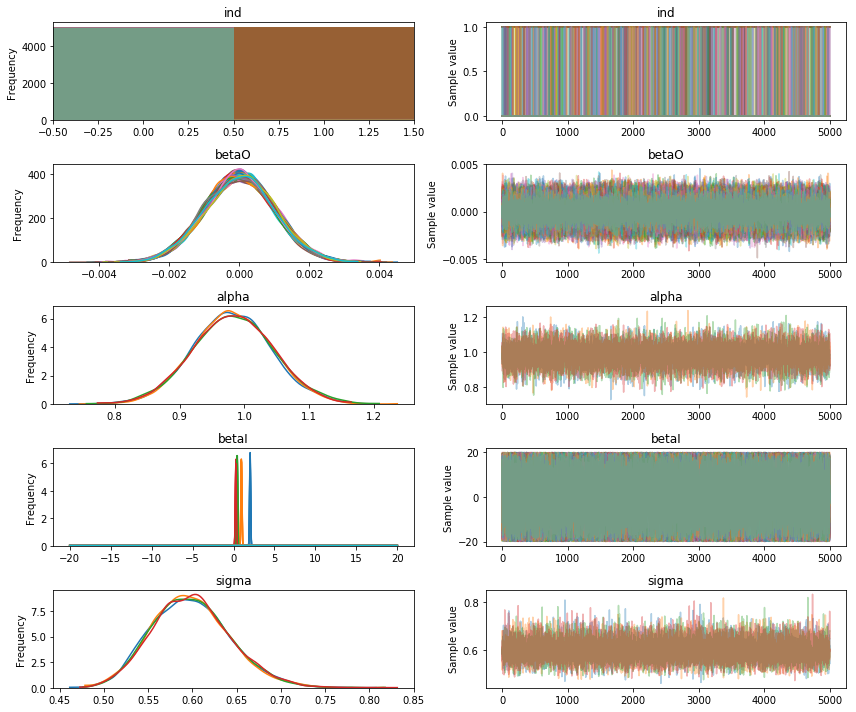

In [13]:
pm.traceplot(trace)

In [16]:
0.04523/np.sqrt(20000)

0.00031982439713067542

In [23]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
ind__0,1.000000e+00,0.000000,0.000000,1.000000,1.000000,20000.0,NaN
ind__1,1.000000e+00,0.000000,0.000000,1.000000,1.000000,20000.0,NaN
ind__2,1.000000e+00,0.000000,0.000000,1.000000,1.000000,20000.0,NaN
ind__3,1.000000e+00,0.000000,0.000000,1.000000,1.000000,20000.0,NaN
ind__4,1.000000e+00,0.000000,0.000000,1.000000,1.000000,20000.0,NaN
ind__5,9.978000e-01,0.046853,0.002189,1.000000,1.000000,12.0,1.004329
ind__6,9.158000e-01,0.277688,0.027137,0.000000,1.000000,10.0,1.079163
ind__7,8.370000e-01,0.369366,0.036495,0.000000,1.000000,7.0,1.242419
ind__8,2.911500e-01,0.454293,0.044653,0.000000,1.000000,5.0,1.507238
ind__9,1.000000e-04,0.009999,0.000070,0.000000,0.000000,20000.0,0.999967


In [19]:
model_two = pm.Model()

with model_two:
    
    # Priors
    ind = pm.Bernoulli('ind',p=0.2,shape=p)
    taub = pm.Gamma('taub', alpha=1, beta=0.001)
    betaO = pm.Normal('betaO',mu=0,sd=taub,shape=p)
    betaI = pm.Uniform('betaI',lower=-20,upper=20,shape=p)
    beta = (1-ind)*betaO+ind*betaI
    alpha = pm.Normal('alpha',mu=0,sd=1)
    sigma = pm.HalfNormal('sigma',sd=1)
    # Expected value
    mu = alpha + pmath.dot(X,beta)
    
    # Likelihood
    Y_obs = pm.Normal('Y_obs',mu=mu,sd=sigma,observed=Y)

In [23]:
with model_two:
    start = pm.find_MAP(method='Powell')
    trace=pm.sample(10000,start=start)

  0%|          | 0/5000 [00:00<?, ?it/s]/home/joele119/anaconda2/envs/bayes_env/lib/python3.6/site-packages/scipy/optimize/_minimize.py:381: RuntimeWarning: Method Powell does not use gradient information (jac).
  RuntimeWarning)
logp = -182.02, ||grad|| = 0.66945: 100%|██████████| 2270/2270 [00:00<00:00, 3524.47it/s]
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [ind]
>NUTS: [sigma_log__, alpha, betaI_interval__, betaO, taub_log__]
100%|█████████▉| 10483/10500 [00:35<00:00, 297.23it/s]/home/joele119/anaconda2/envs/bayes_env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
100%|██████████| 10500/10500 [00:35<00:00, 297.37it/s]
/home/joele119/anaconda2/envs/bayes_env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/joele119/anaconda2/envs/bayes_env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: Runt

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f94ad5ef710>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f94ad36b6a0>]], dtype=object)

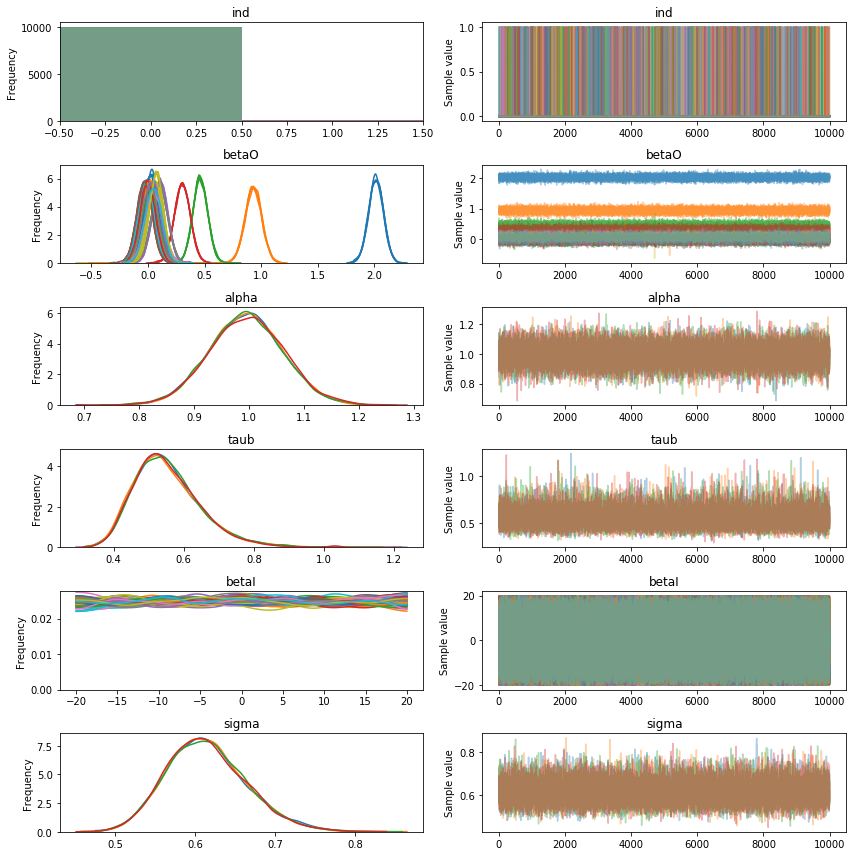

In [24]:
pm.traceplot(trace)

In [25]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
ind__0,0.003125,0.055814,0.000564,0.000000,0.000000,8790.0,1.000387
ind__1,0.003050,0.055143,0.000652,0.000000,0.000000,6616.0,1.000328
ind__2,0.002775,0.052605,0.000466,0.000000,0.000000,11740.0,1.000060
ind__3,0.003275,0.057134,0.000628,0.000000,0.000000,6914.0,1.000134
ind__4,0.003325,0.057567,0.000812,0.000000,0.000000,4756.0,1.000262
ind__5,0.003400,0.058210,0.000922,0.000000,0.000000,3743.0,1.000322
ind__6,0.002175,0.046586,0.000380,0.000000,0.000000,18348.0,1.000057
ind__7,0.002775,0.052605,0.000770,0.000000,0.000000,4627.0,1.000522
ind__8,0.002525,0.050186,0.000641,0.000000,0.000000,6113.0,1.000059
ind__9,0.002125,0.046049,0.000297,0.000000,0.000000,19829.0,1.000117


In [30]:
pm.Beta?

In [26]:
model_three = pm.Model()

with model_three:
    
    # Priors
    taub = pm.InverseGamma('taub', alpha=1, beta=0.001)
    pind = pm.Beta('pind',alpha=2,beta=8)
    ind = pm.Bernoulli('ind',p=pind,shape=p)
    betaO = pm.Normal('betaO',mu=0,sd=taub,shape=p)
    betaI = pm.Uniform('betaI',lower=-20,upper=20,shape=p)
    beta = (1-ind)*betaO+ind*betaI
    alpha = pm.Normal('alpha',mu=0,sd=1)
    sigma = pm.HalfNormal('sigma',sd=1)
    # Expected value
    mu = alpha + pmath.dot(X,beta)
    
    # Likelihood
    Y_obs = pm.Normal('Y_obs',mu=mu,sd=sigma,observed=Y)

In [27]:
with model_three:
    # find a starting point
#     start = pm.find_MAP()
    # draw 5000 posterior samples
#     trace = pm.sample(5000, start=start)
    trace = pm.sample(5000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [sigma_log__, alpha, betaI_interval__, betaO, pind_logodds__, taub_log__]
>BinaryGibbsMetropolis: [ind]
 28%|██▊       | 1566/5500 [00:17<00:42, 91.77it/s] /home/joele119/anaconda2/envs/bayes_env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
 29%|██▊       | 1576/5500 [00:17<00:44, 88.87it/s]/home/joele119/anaconda2/envs/bayes_env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
 87%|████████▋ | 4759/5500 [00:51<00:08, 92.09it/s]/home/joele119/anaconda2/envs/bayes_env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
100%|█████████▉| 5489/5500 [01:03<00:00, 86.73it/s]/home/joele119/anaconda2/envs/bayes_env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwar